In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import numpy as np
import matplotlib as mpl
from pylab import rcParams

mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Times New Roman' #picks the font
mpl.rcParams['axes.labelsize']    = 16

import statsmodels.api as sm

In [2]:
# Import Covid-19 data into a pandas table
parser = lambda x: pd.to_datetime(x, utc = True, format = '%m/%d/%Y')
df = pd.read_csv('Bing-COVID19-Data.csv', delimiter=',', parse_dates = True, index_col = "Updated",
                date_parser = parser)

In [3]:
# Create indices
id_global = df["Country_Region"]=="Worldwide"
id_us = ~pd.notna(df["AdminRegion1"]) & (df["Country_Region"]=="United States")
id_march =  df.index >= pd.to_datetime('03/01/2020', utc = True)
id_train = df.index <= pd.to_datetime('05/01/2020', utc = True)

In [98]:
# Train ARMA model w/all the global data date until May
print('ARMA model 5: global, all confirmed cases until May')
print('*'*50)
arma_model_1 = sm.tsa.ARMA(np.log10(df["Confirmed"][id_global & id_train].resample("1D").mean().interpolate()), (1,0), freq = "D").fit(disp = False,tol = 1e-6)
print(arma_model_1.summary())

ARMA model 5: global, all confirmed cases until May
**************************************************
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                  102
Model:                     ARMA(1, 0)   Log Likelihood                 133.865
Method:                       css-mle   S.D. of innovations              0.063
Date:                Wed, 20 May 2020   AIC                           -261.729
Time:                        07:10:26   BIC                           -253.854
Sample:                    01-21-2020   HQIC                          -258.540
                         - 05-01-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.4868      1.995      2.250      0.027       0.578       8.396
ar.L1.Confirm

In [99]:
# Train ARMA model w/all US data date until May for US data
print('ARMA model 2: US, all confirmed cases until May')
print('*'*50)
arma_model_2 = sm.tsa.ARMA(np.log10(df["Confirmed"][id_us & id_train].resample("1D").mean().interpolate()), (1,0), freq = "1D").fit(tol = 1e-6) #(1,0) (7,0)
print(arma_model_2.summary())
#sm.tsa.ARMA()

ARMA model 2: US, all confirmed cases until May
**************************************************
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                  102
Model:                     ARMA(1, 0)   Log Likelihood                 102.631
Method:                       css-mle   S.D. of innovations              0.085
Date:                Wed, 20 May 2020   AIC                           -199.262
Time:                        07:10:27   BIC                           -191.387
Sample:                    01-21-2020   HQIC                          -196.073
                         - 05-01-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.0251      2.958      1.023      0.309      -2.773       8.823
ar.L1.Confirmed  

In [100]:
# Make a prediction w/ARMA model 5 for the May data
date_predict_5 = pd.date_range(start = '2020-05-01', end = '2020-05-25', tz = 'utc')
y_predict_1, y_err_1, conf_1 = arma_model_1.forecast(25)

# prediction for ARMA model k6
y_predict_2, y_err_2, conf_2 = arma_model_2.forecast(25)

<IPython.core.display.Javascript object>


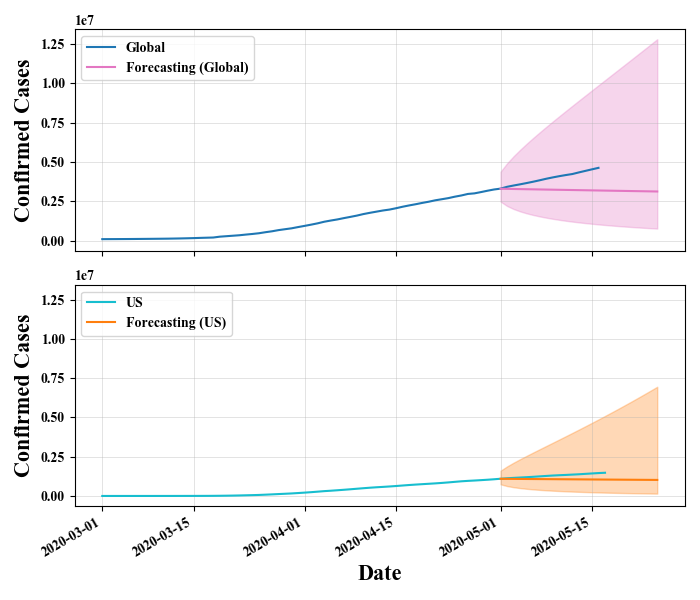

In [101]:
fig, ax = plt.subplots(2,1, figsize = (7,6), sharey = True, sharex = True)
ax[0].plot(df["Confirmed"][id_global & id_march], label = 'Global')
ax[1].plot(df["Confirmed"][id_us & id_march], label = 'US', color = 'tab:cyan')


# plot prediciton w/confidence intervals
ax[0].plot(date_predict_5, 10**(y_predict_1), color = 'tab:pink', label = 'Forecasting (Global)')
ax[0].fill_between(date_predict_5, 10**(conf_1[:,0]), 10**(conf_1[:,1]), alpha = 0.3,
                 color = 'tab:pink')
# for US model
ax[1].plot(date_predict_5, 10**(y_predict_2), color = 'tab:orange', label = 'Forecasting (US)')
ax[1].fill_between(date_predict_5, 10**(conf_2[:,0]), 10**(conf_2[:,1]), alpha = 0.3,
                  color = 'tab:orange')

ax[0].set_ylabel('Confirmed Cases', size = 16)
ax[1].set_ylabel('Confirmed Cases', size = 16)
ax[1].set_xlabel('Date', size = 16)
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')

ax[0].grid(lw = 0.5, alpha = 0.5)
ax[1].grid(lw = 0.5, alpha = 0.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.ylabel()
fig.autofmt_xdate()
fig.tight_layout()
#fig.savefig('confirmed_cases_plot', dpi=400, bbox_inches = 'tight')

In [88]:
"""
Make a deaths from CoVID-19 model, w/the global data 

The US data on deaths from CoVID-19 is too small to create any accurate models.
"""
arma_model_1d = sm.tsa.ARMA(df["Deaths"][id_global & id_train].resample("1D").mean().interpolate(), (4,0), freq = "1D").fit(disp = False)
print(arma_model_1d.summary())

                              ARMA Model Results                              
Dep. Variable:                 Deaths   No. Observations:                  102
Model:                     ARMA(4, 0)   Log Likelihood                -895.039
Method:                       css-mle   S.D. of innovations           1478.572
Date:                Wed, 20 May 2020   AIC                           1802.078
Time:                        07:09:04   BIC                           1817.828
Sample:                    01-21-2020   HQIC                          1808.456
                         - 05-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.713e+04   2.56e+05      0.184      0.854   -4.54e+05    5.49e+05
ar.L1.Deaths     1.4080      0.091     15.423      0.000       1.229       1.587
ar.L2.Deaths    -0.2264      0.160     -1.41

In [89]:
# Make a prediction w/ARMA model 1d for the May data
date_predict = pd.date_range(start = '2020-05-01', end = '2020-05-25', tz = 'utc')
y_predict_1d, y_err_1d, conf_1d = arma_model_1d.forecast(25)

<IPython.core.display.Javascript object>


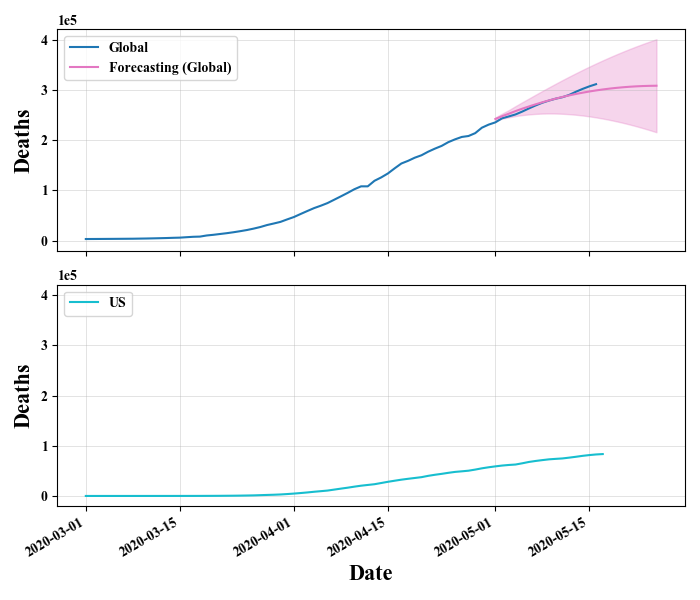

In [91]:
fig, ax = plt.subplots(2,1, figsize = (7,6), sharey = True, sharex = True)
ax[0].plot(df["Deaths"][id_global & id_march], label = 'Global')
ax[1].plot(df["Deaths"][id_us & id_march], label = 'US', color = 'tab:cyan')

# plot prediciton w/confidence intervals
ax[0].plot(date_predict, y_predict_1d, color = 'tab:pink', label = 'Forecasting (Global)')
ax[0].fill_between(date_predict, conf_1d[:,0], conf_1d[:,1], alpha = 0.3,
                  color = 'tab:pink')

ax[1].set_xlabel('Date', size = 16)
ax[0].set_ylabel('Deaths', size = 16)
ax[1].set_ylabel('Deaths', size = 16)
ax[0].grid(lw = 0.5, alpha = 0.5)
ax[1].grid(lw = 0.5, alpha = 0.5)
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.autofmt_xdate()
fig.tight_layout()
#fig.savefig('deaths_plot', dpi=400, bbox_inches = 'tight')